This notebook describes how to implement SIRT using tomosipo. 

Given the tomographic inverse problem
$$ A x = y, $$
The SIRT algorithm updates it's estimate $x$ iteratively as follows:
$$    x_{i+1} = x_i + C  A^T R  (y - A x_i). $$

Here, $R$ and $C$ are diagonal matrices containing the row and column sums of $A$, respectively. 

For more information, see https://tomroelandts.com/articles/the-sirt-algorithm

In [1]:
import torch 
import tomosipo as ts
import astra
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def plot_imgs(height=3, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        pcm = ax.imshow(v.detach().cpu().numpy().squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()



C:\Users\lliu10\Anaconda3\envs\tomosipo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


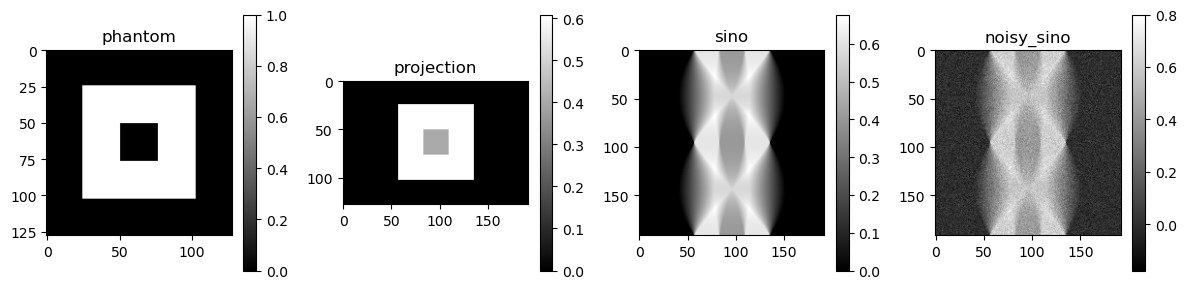

In [2]:
# Volume is the unit cube with N^3 voxels. 
# projection geometry is 1.5 units wide and 1 unit high.
N = 128
full_vg = ts.volume(size=1, shape=N)
full_pg = ts.parallel(angles=3 * N // 2, shape=(N, 3 * N // 2), size=(1, 1.5))
A = ts.operator(full_vg, full_pg)

phantom = ts.phantom.hollow_box(ts.data(full_vg)).data
phantom = torch.from_numpy(phantom)
sino = A(phantom)
noisy_sino = sino + sino.max() / 20 * torch.randn_like(sino)

plot_imgs(
    phantom=phantom[64],       # central axial slice
    projection=sino[:, 0, :],  # first projection image
    sino=sino[64, ...],        # sinogram of central slice
    noisy_sino=noisy_sino[64, ...], # noisy sinogram
)    

In [4]:
# Naive SIRT implementation.

# We can either create tensors directly on the GPU, or create 
# tensors on the CPU --- using `torch.device("cpu")` --- and 
# let ASTRA move the data back and forth. This results in a kind
# of "ping pong" effect, where the data is moved to and from GPU 
# just for ASTRA. Therefore, if you change the device to "cpu", 
# you will find that performance is roughly halved. 
dev = torch.device("cuda")
#dev = torch.device("cpu")
num_iters = 100

y = noisy_sino.to(dev)
x_cur = torch.zeros(A.domain_shape, device=dev)

C = A.T(torch.ones(A.range_shape, device=dev))
C[C < ts.epsilon] = np.Inf
C.reciprocal_()

R = A(torch.ones(A.domain_shape, device=dev))
R[R < ts.epsilon] = np.Inf
R.reciprocal_()

# Just like the formula :) 
for i in tqdm(range(num_iters)):
    x_cur += C * A.T(R * (y - A(x_cur)))
    
plot_imgs(
    reconstruction=x_cur[64], 
    phantom=phantom[64],
    diff = (x_cur.cpu() - phantom)[64],
)    

AssertionError: Torch not compiled with CUDA enabled

100%|██████████| 100/100 [00:01<00:00, 77.94it/s]


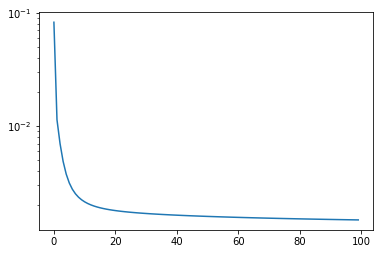

In [81]:
# Here, we implement a slightly more optimized version. 
# This is not much faster, but it avoids allocating some intermediate tensors, 
# which is nice when you are close to the memory limit. 

y_tmp = torch.ones(A.range_shape, device=dev)
C = A.T(y_tmp)
C[C < ts.epsilon] = np.Inf
C.reciprocal_()

x_tmp = torch.ones(A.domain_shape, device=dev)
R = A(x_tmp)
R[R < ts.epsilon] = np.Inf
R.reciprocal_()

y = noisy_sino.to(dev)
x_cur = torch.zeros(A.domain_shape, device=dev)

residuals = np.zeros(num_iters)
for i in tqdm(range(num_iters)):
    A(x_cur, out=y_tmp)
    y_tmp -= y    # flip sign here
    
    # We can keep track of the residual error in the projection data
    residuals[i] = torch.square(y_tmp).mean()
    
    y_tmp *= R
    A.T(y_tmp, out=x_tmp)
    x_tmp *= C
    x_cur -= x_tmp # flip sign here
    
plt.plot(residuals)
plt.yscale('log')

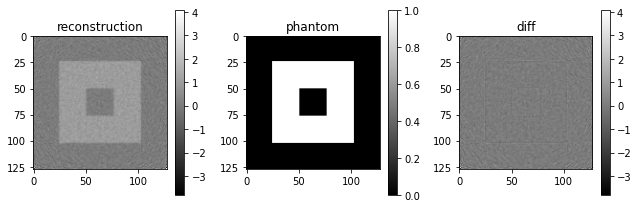

In [82]:
plot_imgs(
    reconstruction=x_cur[64], 
    phantom=phantom[64],
    diff = (x_cur.cpu() - phantom)[64],
#     clim=(-.1, 1.1),
)

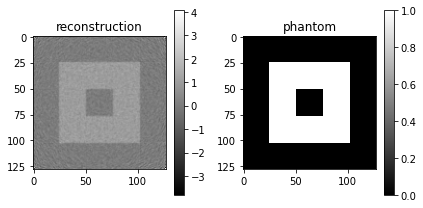

In [83]:
# You can also use ASTRA's internal SIRT algorithm, which has the same speed. 

vd = ts.data(full_vg)
pd = ts.data(full_pg, noisy_sino)
with vd, pd:
    rec_id = vd.to_astra()
    sinogram_id = pd.to_astra()
    cfg = astra.astra_dict('SIRT3D_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, num_iters)
    
    # Make a copy of the reconstruction before we delete it. 
    astra_rec = torch.from_numpy(np.copy(vd.data))
    # Delete algorithm
    astra.algorithm.delete(alg_id)

plot_imgs(
    reconstruction=astra_rec[64], 
    phantom=phantom[64],
)    

In [84]:
# The difference between the two implementations is negligible :) 
abs(astra_rec - x_cur.cpu()).mean()

tensor(3.2945e-08)

To delve into the speed differences between ASTRA's SIRT3D_CUDA algorithm and the implementation 
in tomosipo described above, please see sirt_benchmark.py. 

I have found that the optimized tomosipo implementation is slightly faster. 